<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%204/Week_4_Tugas_RNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, output_size=10):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Ambil output dari langkah terakhir
        return out

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training model
def train_model():
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28, 28)  # Reshape untuk RNN

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}')

# Evaluasi model
def evaluate_model():
    model.eval()
    actuals, predictions = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            actuals.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

    return actuals, predictions

# Run training and evaluation
train_model()
actuals, predictions = evaluate_model()

# Save results for visualization
np.savez("mnist_rnn_results.npz", actuals=actuals, predictions=predictions)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.99MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.90MB/s]


Epoch [1/10], Loss: 0.3563
Epoch [2/10], Loss: 0.0908
Epoch [3/10], Loss: 0.0624
Epoch [4/10], Loss: 0.0509
Epoch [5/10], Loss: 0.0419
Epoch [6/10], Loss: 0.0357
Epoch [7/10], Loss: 0.0299
Epoch [8/10], Loss: 0.0281
Epoch [9/10], Loss: 0.0232
Epoch [10/10], Loss: 0.0225
MSE: 0.2111, RMSE: 0.4595, R2: 0.9748


# TensorFlow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load MNIST dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    return image, label

dataset, info = tfds.load("mnist", as_supervised=True, with_info=True)
train_data = dataset['train'].map(lambda img, lbl: preprocess(img, lbl)).batch(128).shuffle(10000)
test_data = dataset['test'].map(lambda img, lbl: preprocess(img, lbl)).batch(128)


# Define RNN model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(28, 28)),
    Dropout(0.3),
    LSTM(256),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_data, epochs=15, validation_data=test_data)

# Evaluate model
actuals, predictions = [], []
for images, labels in test_data:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    actuals.extend(labels.numpy())
    predictions.extend(preds)

# Compute evaluation metrics
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

# Save results for visualization
np.savez("mnist_rnn_results_tf.npz", actuals=actuals, predictions=predictions)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 282s 577ms/step - accuracy: 0.6954 - loss: 0.8990 - val_accuracy: 0.9578 - val_loss: 0.1374
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 314s 570ms/step - accuracy: 0.9572 - loss: 0.1395 - val_accuracy: 0.9689 - val_loss: 0.0973
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 271s 575ms/step - accuracy: 0.9721 - loss: 0.0888 - val_accuracy: 0.9732 - val_loss: 0.0912
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 272s 575ms/step - accuracy: 0.9807 - loss: 0.0616 - val_accuracy: 0.9821 - val_loss: 0.0564
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 322s 577ms/step - accuracy: 0.9851 - loss: 0.0486 - val_accuracy: 0.9799 - val_loss: 0.0644
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 272s 577ms/step - accuracy: 0.9870 - loss: 0.0416 - val_accuracy: 0.9834 - val_loss: 0.0503
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 273s 578ms/step - accuracy: 0.9884 - loss: 0.0357 - val_accuracy: 0.9849 - val_loss: 0.0479
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 314s 563ms/step - accuracy: 0.9920 - loss: 0.02

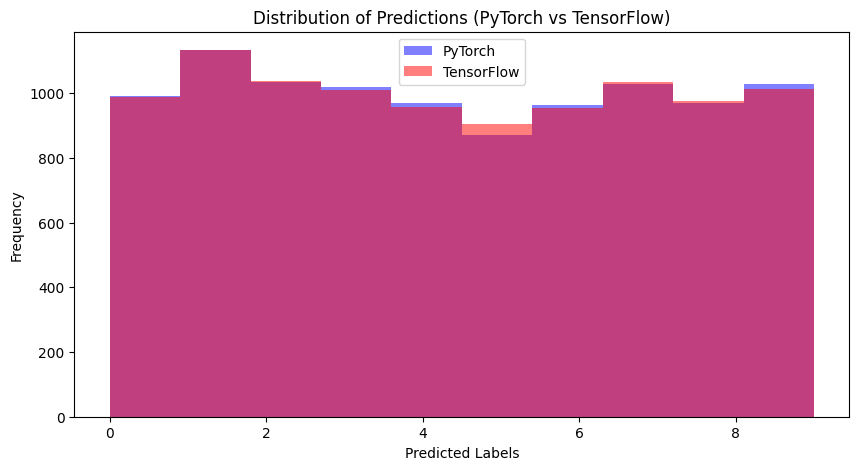

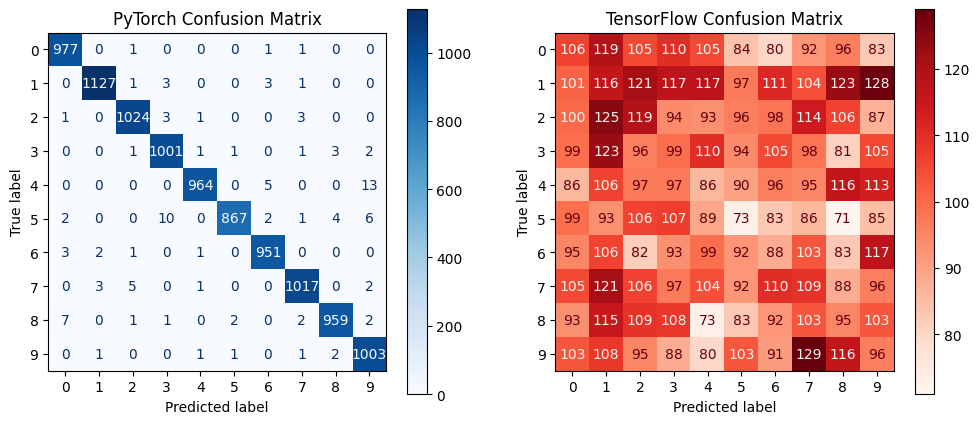

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load results
pytorch_results = np.load("mnist_rnn_results.npz")
tensorflow_results = np.load("mnist_rnn_results_tf.npz")

actuals = pytorch_results["actuals"]
pred_pytorch = pytorch_results["predictions"]
pred_tensorflow = tensorflow_results["predictions"]

# Plot comparison
plt.figure(figsize=(10, 5))
plt.hist(pred_pytorch, bins=10, alpha=0.5, label='PyTorch', color='blue')
plt.hist(pred_tensorflow, bins=10, alpha=0.5, label='TensorFlow', color='red')
plt.xlabel("Predicted Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions (PyTorch vs TensorFlow)")
plt.legend()
plt.show()

# Compute confusion matrices
cm_pytorch = confusion_matrix(actuals, pred_pytorch)
cm_tensorflow = confusion_matrix(actuals, pred_tensorflow)

# Display confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_pytorch).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("PyTorch Confusion Matrix")
ConfusionMatrixDisplay(cm_tensorflow).plot(ax=axes[1], cmap='Reds')
axes[1].set_title("TensorFlow Confusion Matrix")
plt.show()

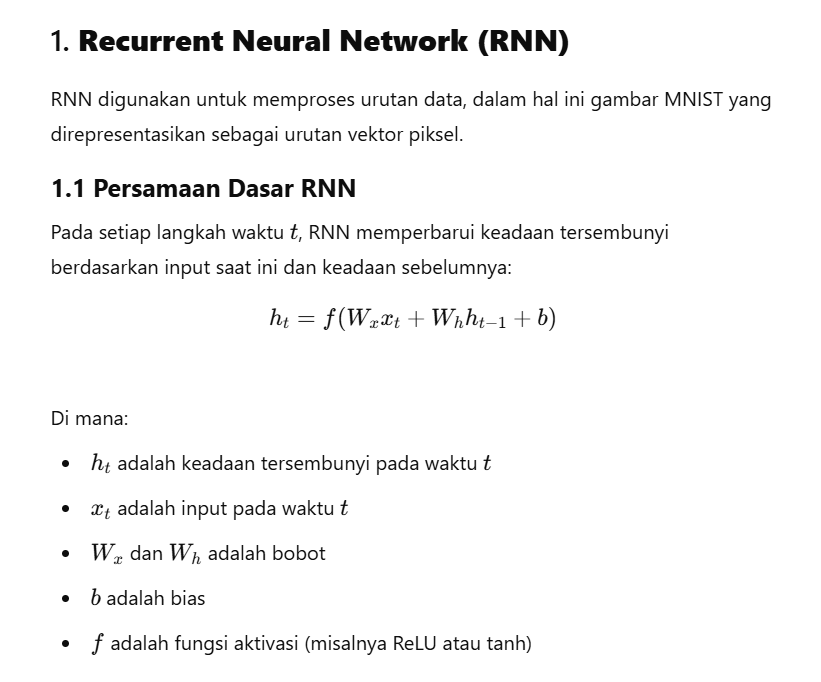

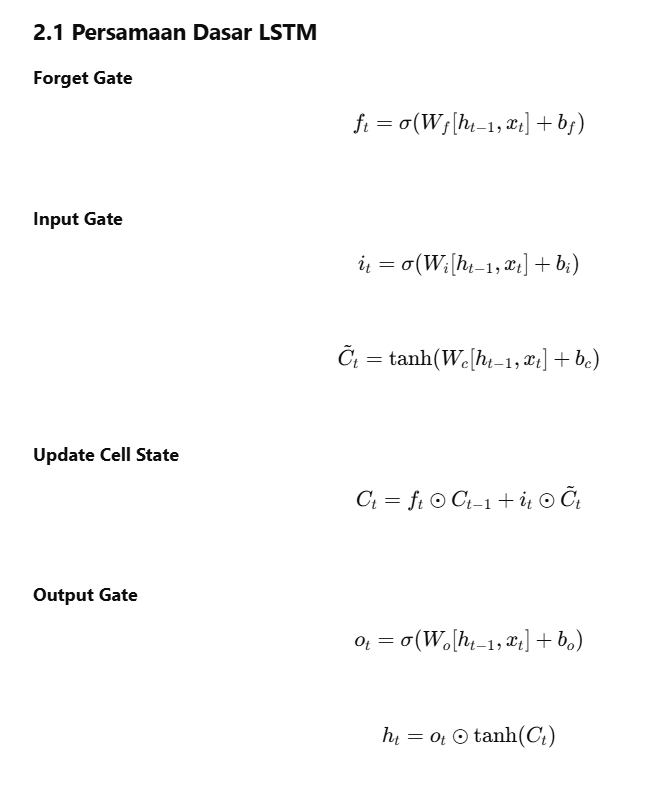

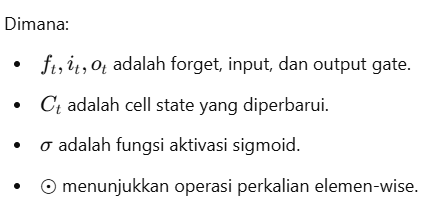

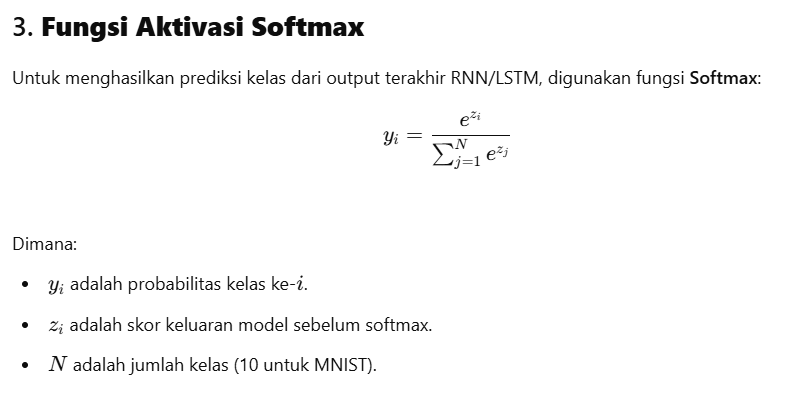

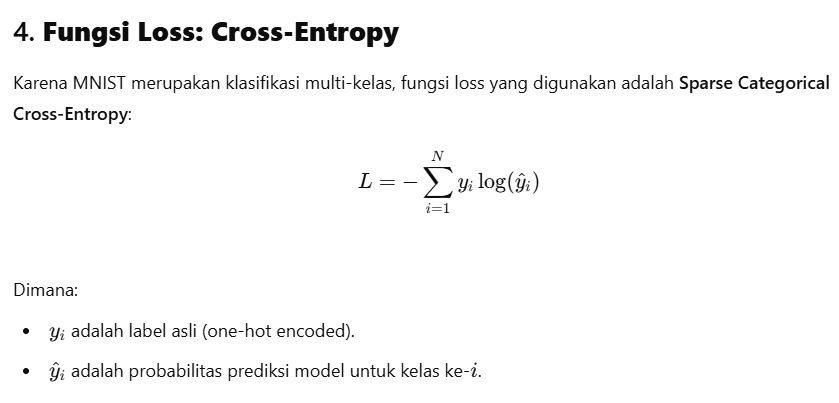

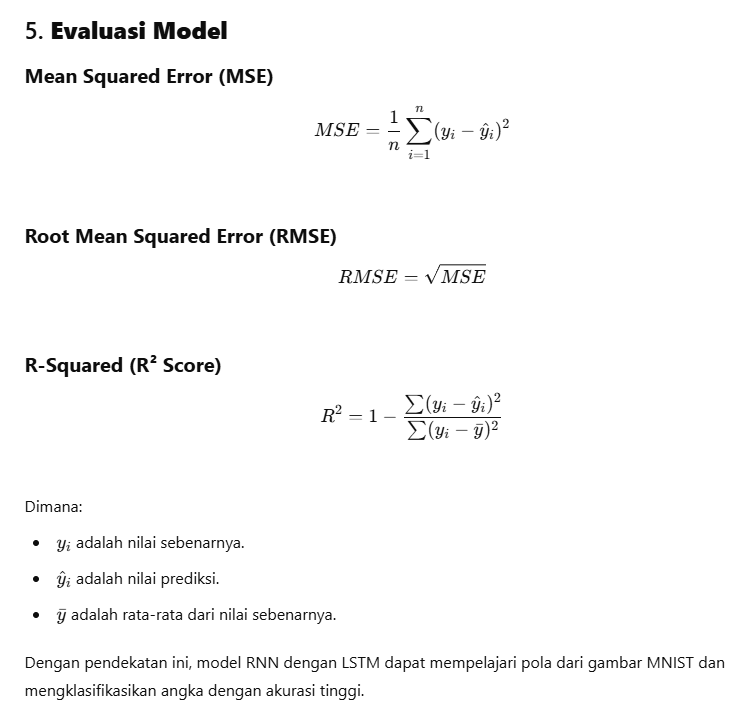